#

## Peak detection

### Introduction
In this notebook, we will compute R peak detection using two methods. The first technique uses an open-source library that processes lead signals, and computes beats per minute (BPM) and interbeat interval (IBI) automatically. The second method is an implementation of the Pank Tompkins algorithm in which we manually compute BPM and IBI.

Once we have identified the R-peaks, we will plot them to see the results, assess the precision of the calculations compared to the R-peaks provided in the dataset.

### Initialization
Let's start by loading the necessary libraries for the notebook.

In [53]:
import numpy as np 
import pandas as pd 
import wfdb 
import ast
import json
import matplotlib.pyplot as plt
import heartpy as hp
from scipy.signal import butter, filtfilt, find_peaks
from tqdm import tqdm

Then, we will design the function that will identify the location of the R-peaks. This function takes an options dictionary where we stored all the variables of interest, a multi-lead ECG signal, its meta-data, and a boolean value that defines the method that will be used &ndash; the heartPy library, or the Pan Tompkins algorithm.

If we decided to use the heartPy library, the function uses by default the lead I. We decided to go by default with the lead I after a visual assessment of R-peak detection performance. Note that HeartPy will automatically reject R-peaks, and will not compute BPM or IBI if there are not enough R-peaks after removal. If that were the case, the function conducts R-peak detection using lead II as recommended by the [NIH](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1122339/). However, sometimes lead II can be too noisy for the library to detect R-peaks. In case using the raw lead II of the ECG fails, it bandpass filters the signal between 0.5 and 15 Hz, and re-calculates the BPM. 

On the other hand, if we choose the alternative option, the function computes R-peak detection using Pan Tompkins. First, it filters the raw signal with a 3<sup>rd</sup> order forward and backward bandpass Butterworth filter between 0.5 and 15 Hz to remove baseline drifts and undesirable high frequencies. Then, it differentiates the signal, squares it, and applies moving-average filtering with a window size of 5 samples to enhance R-peaks. Finally, it uses scipy's *find_peaks* function. We've set a minimum potential of 80% of the signal's maximum potential to avoid detecting T-waves, and a minimum separation of 1.1 times the heart's refractory period (250 ms) to avoid detecting close local maxima. We remove half of the window's size from each detected peak's location to compensate for the offset induced by the moving average.

In [132]:

def get_r_peaks(opts:dict, signal:np.ndarray, meta:dict, detectors:bool=True) -> list():
    """get_r_peaks Provided a signal and the meta data, returns the R-peaks location, BPM and IBI

    Args:
        opts (dict): Options dictionnary with variable values.
        signal (np.ndarray): Multi-lead ECG signal.
        meta (dict): Signal's meta-data.
        detectors (boolean): True, to use heartpy library. False, to use manual calcualtion
        

    Returns:
        _type_: _description_
    """
    
    # If detectors, use library
    if detectors:
        wd, m = hp.process(signal[:,0], sample_rate=meta['fs'], windowsize=0.15)                
        if np.isnan(m['bpm']):
            wd, m = hp.process(signal[:,1], sample_rate=meta['fs'], windowsize=0.15)      
            if np.isnan(m['bpm']):   
                signal = hp.filter_signal(signal[:,1], sample_rate=meta['fs'], cutoff=[0.5,15], filtertype='bandpass')
                wd, m = hp.process(signal, sample_rate=meta['fs'], windowsize=0.15)      

        return wd['peaklist'], m['bpm'], m['ibi']
    
    # Else, compute the R-peaks: Use lead I, butterworth filtering, and find_peaks with 1.1 times the refractory period.
    else:
        signal=signal[:,0]
        order, lc, hc = opts['var']['order'], opts['var']['low_cut'], opts['var']['high_cut']
        fs = opts['var']['fs']
        b, a = butter(order, [lc, hc], fs=fs, btype='band', output='ba')
        filt_sig = filtfilt(b, a, signal)
        r_period = 0.25
        diff_sig = np.diff(filt_sig)
        squared_sig = np.square(diff_sig)
        ma_sig = np.convolve(squared_sig, np.ones(10)/10)[0:1000]
        peaks = find_peaks(ma_sig, height=0.5*np.max(ma_sig), distance=1.1*r_period*fs)[0]-5
        bpm = len(peaks)*60/(len(signal)/fs)
        ibi = np.mean(np.diff(peaks/fs))*1000
        return peaks, bpm, ibi
        


We now load the options dictionary, where we store paths and variables of interest such as the low and high cut for the bandpass filters. Then, we read the database file.

In [60]:
# load options
with open('opts.json','r') as inFile:
    opts = json.load(inFile)
    
# Read database
database_df = pd.read_csv(opts['file']['ptbxl_database_processed'])


Since one of the tasks was to annotate meta-data, we have created this for loop that iterates over all subjects and computes R-peaks using heartPy and manual computation. However, to not mess up the original meta-data, annotations are stored in *.hea* format in a separate folder. **Disclaimer**: because of the three *if* statements of the auxiliary function and large dataset, this iterative loop will take a long time to run, and we do not recommend running it. It is just to ensure that all tasks requested are accomplished.

In [ ]:
# Iterate over subjects 
for idx, subj in tqdm(database_df.iterrows()):
        
    # Read signal 
    signal, meta = wfdb.rdsamp(opts['path']['physionet'] + subj.filename_lr)
    
    # Get r-peaks and bpm, ibi
    peaks, bpm, ibi = get_r_peaks(opts, signal, meta, detectors=True)
    peaks_man, bpm_man, ibi_man = get_r_peaks(opts, signal, meta, detectors=False)
    
    # Add to meta-data
    meta['peaks'], meta['bpm'], meta['ibi'] = list(map(int,peaks)), str(bpm), int(ibi)
    meta_man = meta.copy()
    meta_man['peaks'], meta_man['bpm'], meta_man['ibi'] = peaks_man.tolist(), bpm_man, ibi_man
    
    # Write
    subj_name = subj.filename_lr.split('/')[-1]
    with open(opts['path']['annotations'] + subj_name + '.hea', 'w') as outFile:
        json.dump(meta, outFile)
    with open(opts['path']['annotations'] + subj_name + '_man.hea', 'w') as outFile:
        json.dump(json.dumps(meta_man), outFile)
  

### Plots and comparison

Let's now take a look at how our two options did detection R-peaks. We'll look only at leads I, II, and III for simplicity. Note that we will plot all R-peaks detected by heartPy, including the rejected ones.

[]

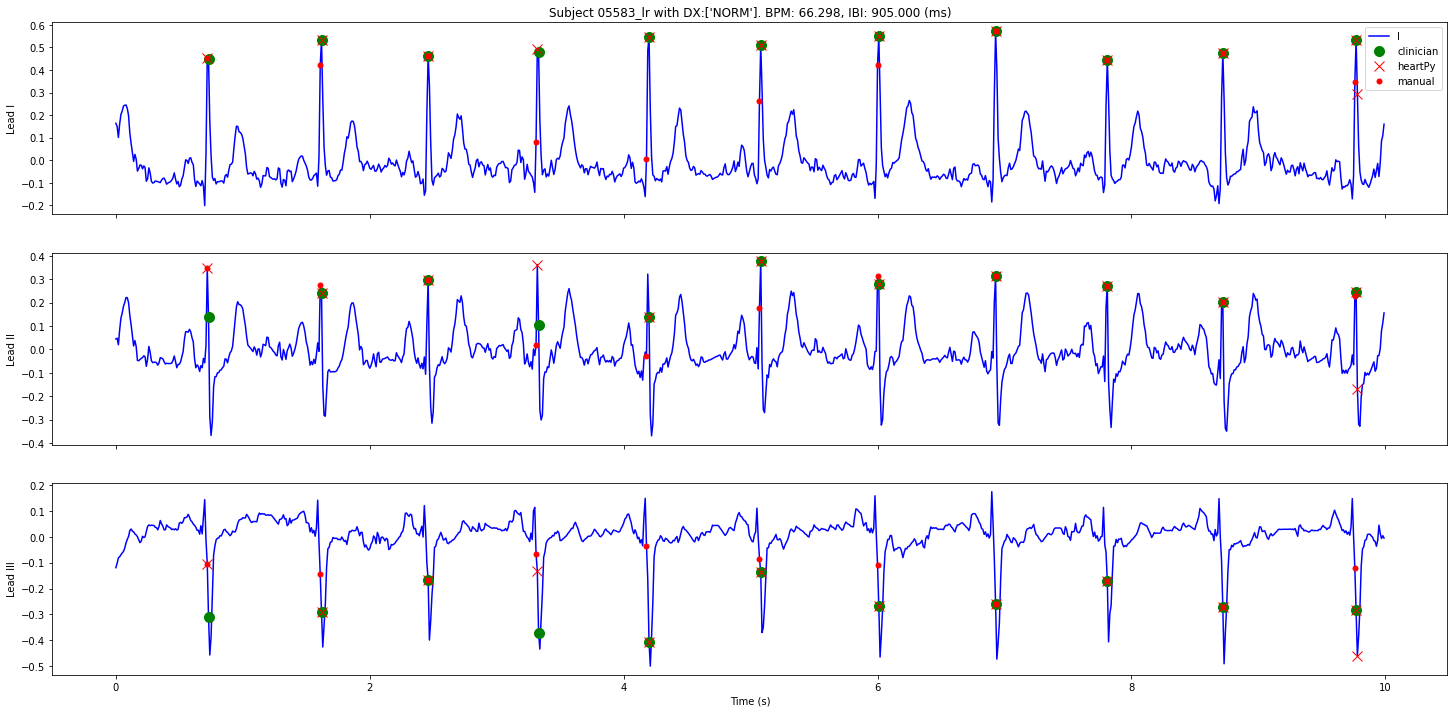

In [142]:
# Load random subject
subj = database_df.sample()
signal, meta = wfdb.rdsamp(opts['path']['physionet'] + subj.filename_lr.iloc[0])
r_p = ast.literal_eval(subj.r_peaks.iloc[0])

# Get r-peaks and bpm, ibi
peaks, bpm, ibi = get_r_peaks(opts, signal, meta, detectors=True)
peaks_man, bpm_man, ibi_man = get_r_peaks(opts, signal, meta, detectors=False)

# Convert peaks to seconds
peaks_s, peaks_man_s, r_p_s = np.divide(peaks,meta['fs']), np.divide(peaks_man,meta['fs']), np.divide(r_p,meta['fs'])

# Plot 
%matplotlib inline
plt.rcParams['figure.figsize']=(25,12)
signal_df = pd.DataFrame(signal)
signal_df.columns = meta['sig_name']
signal_df['t_vec'] = np.arange(0, signal.shape[0])/meta['fs']
axes = signal_df.plot(x = 't_vec', y = [0,1,2], subplots=True, color='blue', legend=False, ylabel='Time (s)')
axes[0].set_title('Subject {} with DX:{}. BPM: {:.3f}, IBI: {:.3f} (ms)'.format(subj.filename_lr.iloc[0].split('/')[-1], subj.dx_super.iloc[0], bpm, ibi))
for i in range(0,3):
    axes[i].set_ylabel('Lead ' + meta['sig_name'][i])
    axes[i].plot(r_p_s, signal[r_p, i],'go',markersize=10, label='clinician')
    axes[i].plot(peaks_s, signal[peaks,i], 'rx',markersize=10, label='heartPy')
    axes[i].plot(peaks_man_s, signal[peaks_man,i], 'ro',markersize=5, label='manual')
axes[0].legend(loc='upper right')
axes[-1].set_xlabel('Time (s)')
plt.plot()



It looks okay! If we try with some subjects we see that sometimes, the heartPy method creates a lot of false positives (two peaks too close to each other) and that the manual method is some samples apart from the clinician's marker.

/home/vicente/.local/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


[]

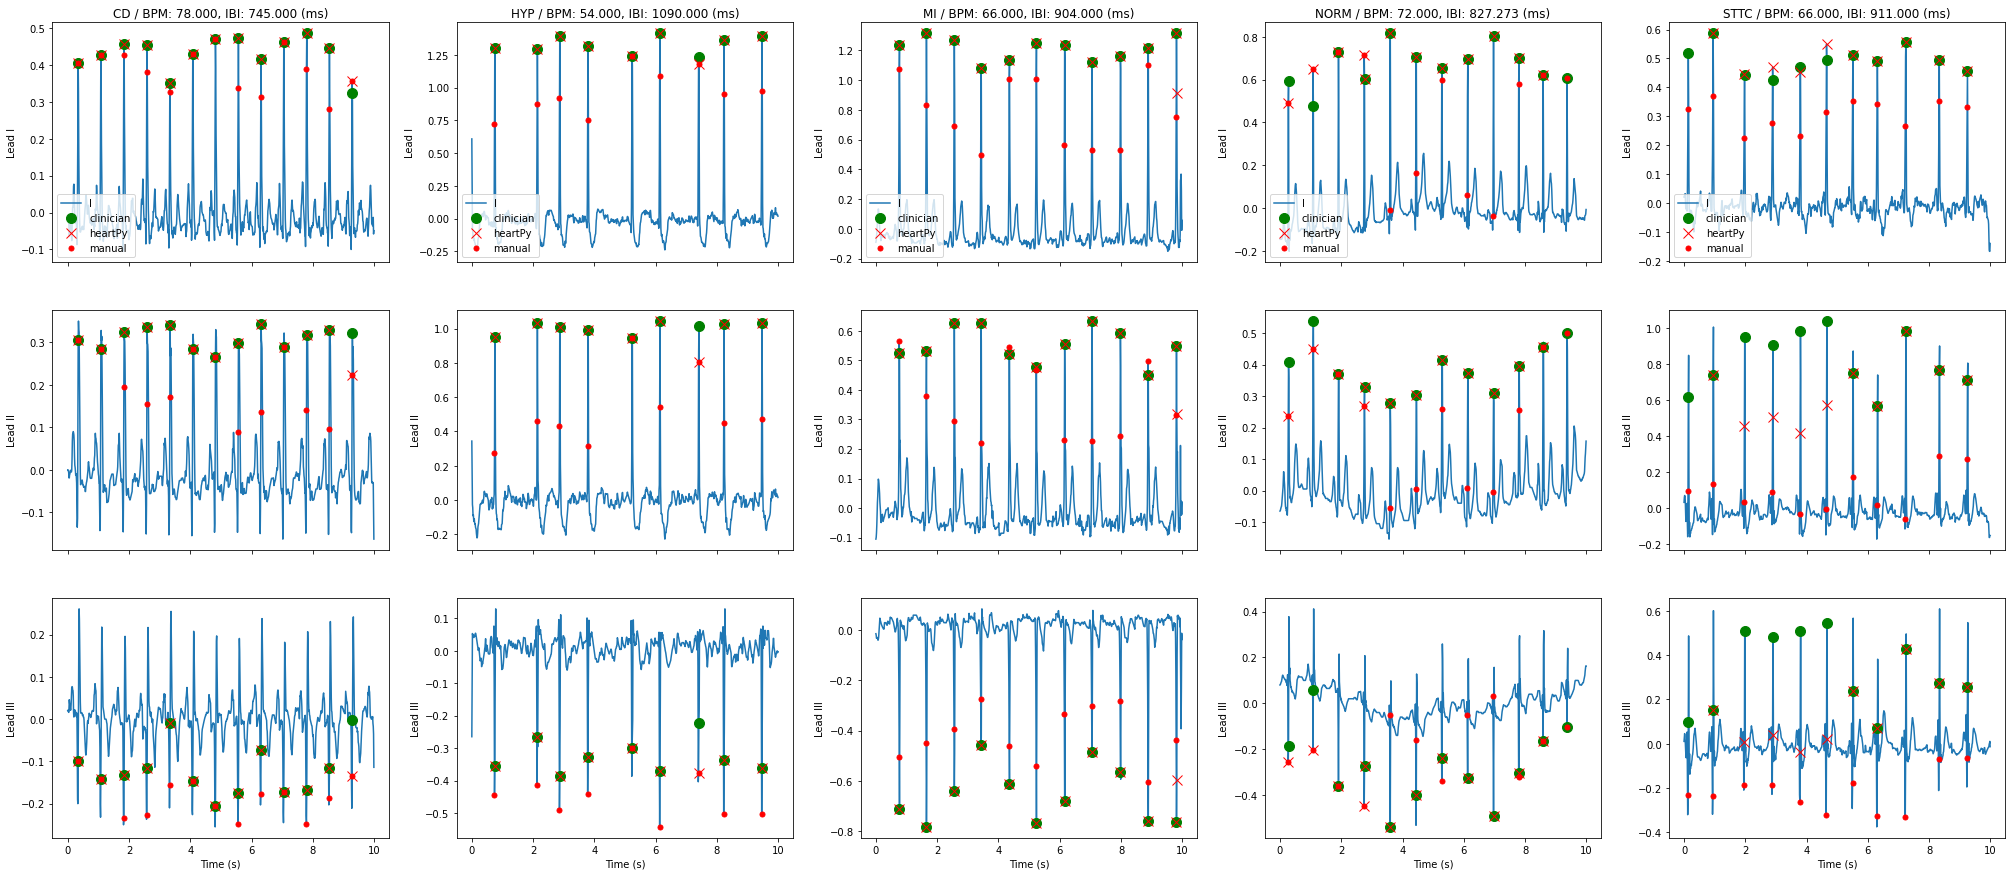

In [145]:
# Dx classes
dx_classes = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

# Plot 
%matplotlib inline 
plt.rcParams['figure.figsize']=(35,15)
fig, axes = plt.subplots(3,5, sharey=False, sharex=True)
for idx, dx in enumerate(dx_classes):
    
    # Get random subject 
    subj = database_df.loc[database_df[dx] == 1].sample()
    signal, meta = wfdb.rdsamp(opts['path']['physionet'] + subj.filename_lr.iloc[0])
    r_p = ast.literal_eval(subj.r_peaks.iloc[0])
    
    # Get r-peaks and bpm, ibi
    peaks, bpm, ibi = get_r_peaks(opts, signal, meta, detectors=True)
    peaks_man, bpm_man, ibi_man = get_r_peaks(opts, signal, meta, detectors=False)

    # Convert peaks to seconds
    peaks_s, peaks_man_s, r_p_s = np.divide(peaks,meta['fs']), np.divide(peaks_man,meta['fs']), np.divide(r_p,meta['fs'])
        
    # Plot
    signal_df = pd.DataFrame(signal)
    signal_df.columns = meta['sig_name']
    signal_df['t_vec'] = np.arange(0, signal.shape[0])/meta['fs']
    for lead in range(0,3):
        signal_df.plot(y=lead, x='t_vec', ax=axes[lead, idx], legend=False)
        axes[lead,idx].set_ylabel('Lead ' + meta['sig_name'][lead])
        axes[lead,idx].plot(r_p_s, signal[r_p, lead],'go',markersize=10, label='clinician')
        axes[lead,idx].plot(peaks_s, signal[peaks,lead], 'rx',markersize=10, label='heartPy')
        axes[lead,idx].plot(peaks_man_s, signal[peaks_man,lead], 'ro',markersize=5, label='manual')
    axes[0, idx].set_title('{} / BPM: {:.3f}, IBI: {:.3f} (ms)'.format(dx, bpm_man, ibi_man))        
    axes[0,idx].legend(loc='lower left')
    axes[-1, idx].set_xlabel('Time (s)')
plt.plot()



In overall, it looks okay. However, we see a lot of false positives in the heartPy method, and the Pan-Tompkins method can be off by some samples, which could be confusing for the clinician. One of the main drawbacks of the Pan-Tompkin's application is that we've set a minimum potential of 80% the maximum, meaning that if there is a much higher peak than usual, no peaks will be detected. 

### Ideas 

We've seen that in general, both methods do okay, but there are some things that we would have loved to check:
- **Assess the quality of R-peak detection:** Measuring the number of missing and extra peaks detected, as well as the error between the clinician's peaks and the ones detected (in samples and ms). Also, assess the quality of the BPM and IBI computation compared to the IBI and BPM that can be computed by the clinician.
- **Better selection of signal:** In this case we've gone with Lead I as the default signal to detect peaks. However, sometimes other leads could be better. Measuring Signal-to-Noise ratios or others to assess the signal quality and select the best one could have improved results. 

### Future work 

We've seen how our R-peak detector does, but there is much more work to be done. Given that some of the diagnoses have a low likelihood, it'd be interesting to check how including them in the training set of a classifier would influence its performance, both in the low-likelihood subjects and the high ones. This could be important, given that the likelihood of the diagnosis is often not included in the clinical information accompanying the data &ndash; should it have an effect, it'd be worth considering asking for it in the future to ensure that it is not disrupting the performance of the model. We've decided not to include this part of the project for lack of time.